In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
wag = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print(wag.shape)
wag.head()

(284, 1)


,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [3]:
wag.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


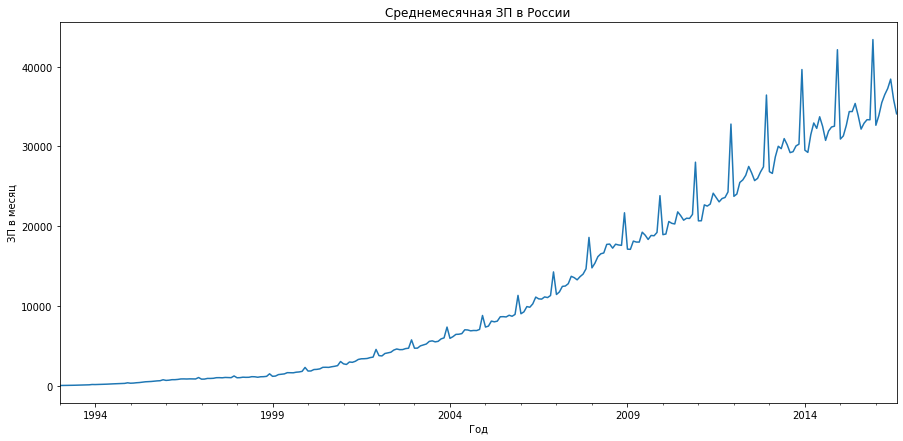

In [4]:
plt.figure(figsize(15,7))
wag['WAG_C_M'].plot()
plt.ylabel('ЗП в месяц')
plt.xlabel('Год')
plt.title('Среднемесячная ЗП в России')
pylab.show()

У данного временного ряда есть ярко выраженный положительный тренд. Так же годовая сезонность. Дисперсия меняется со временем.

Проверим на стационарность и посмотрим на STL-декомпозицию ряда

Нулевая гипотеза: ряд не стационарен.  
Альтернативная гипотеза: ряд стационарен

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

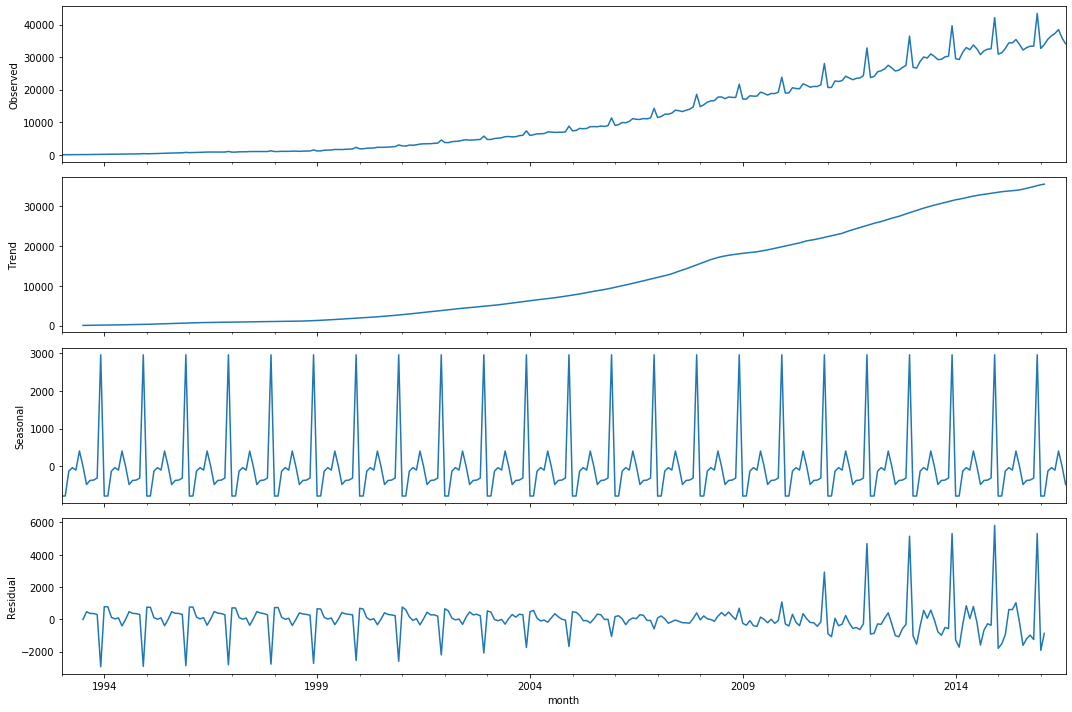

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag['WAG_C_M'])[1])

Тренд и сезонность ещё раз подтверждаются на 2-м и 3-м графиках.

Нулевую гипотезу отвергнуть не можем. Ряд не является стационарным.

Стабилизируем дисперсию преобразованием Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


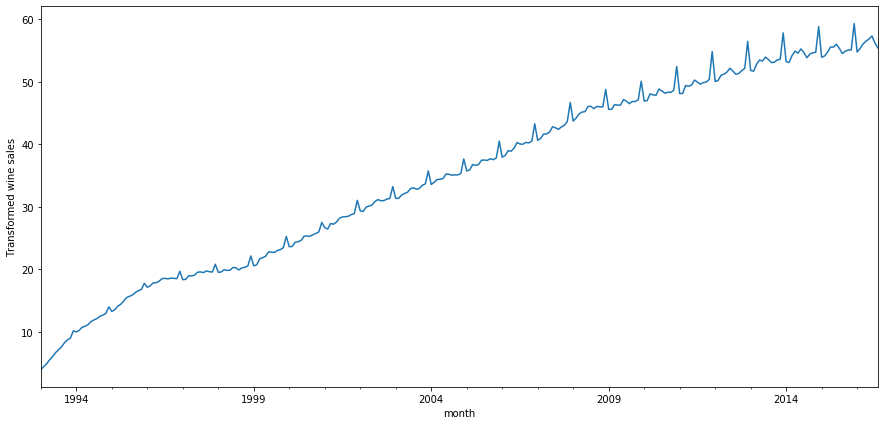

In [6]:
wag['WAG_C_M_box'], lmbda = stats.boxcox(wag['WAG_C_M'])
plt.figure(figsize(15,7))
wag['WAG_C_M_box'].plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag['WAG_C_M'])[1])

Удалось немного стабилизировать дисперсию. Проведём сезонное дифференцирование, где один сезон равен 12 месяцам в данном случае.

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

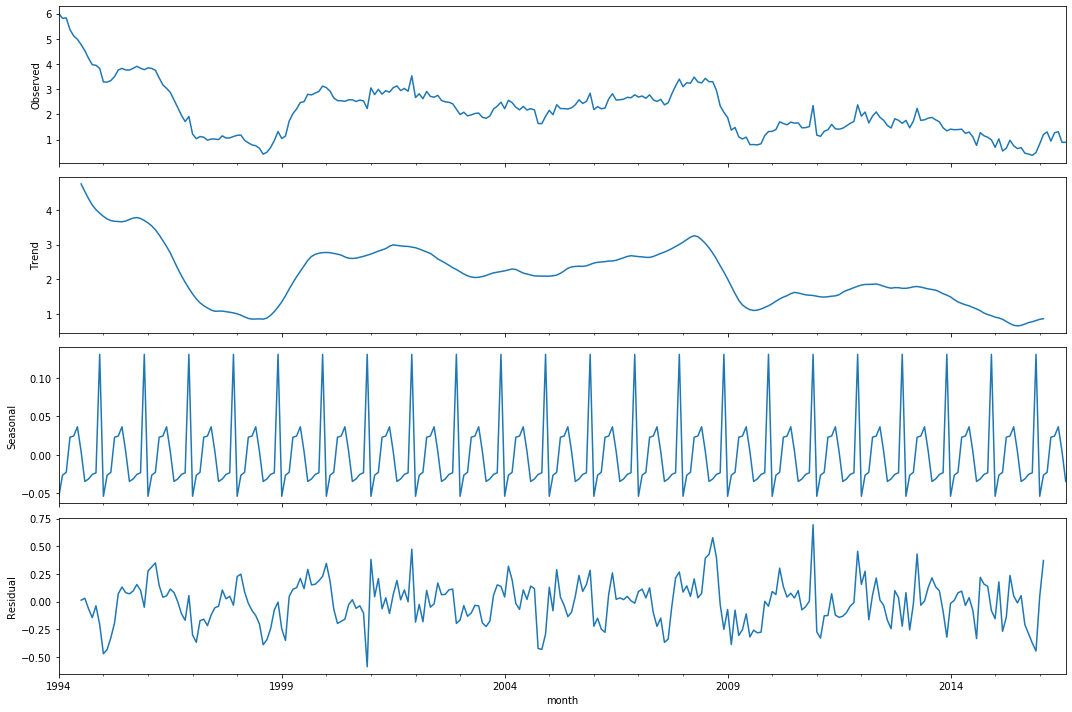

In [7]:
wag['WAG_C_M_diff'] = wag['WAG_C_M_box'] - wag['WAG_C_M_box'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag['WAG_C_M_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag['WAG_C_M_diff'][12:])[1])

Гипотезу о нестационарности можем отвергнуть при p-уровне значимости 0.05, но ряд всё ещё не выглядит стационарным, так как виден чёткий отрицательный тренд на некоторых отрезках. Проведём ещё одно дифференцирование, на это раз несезонное.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

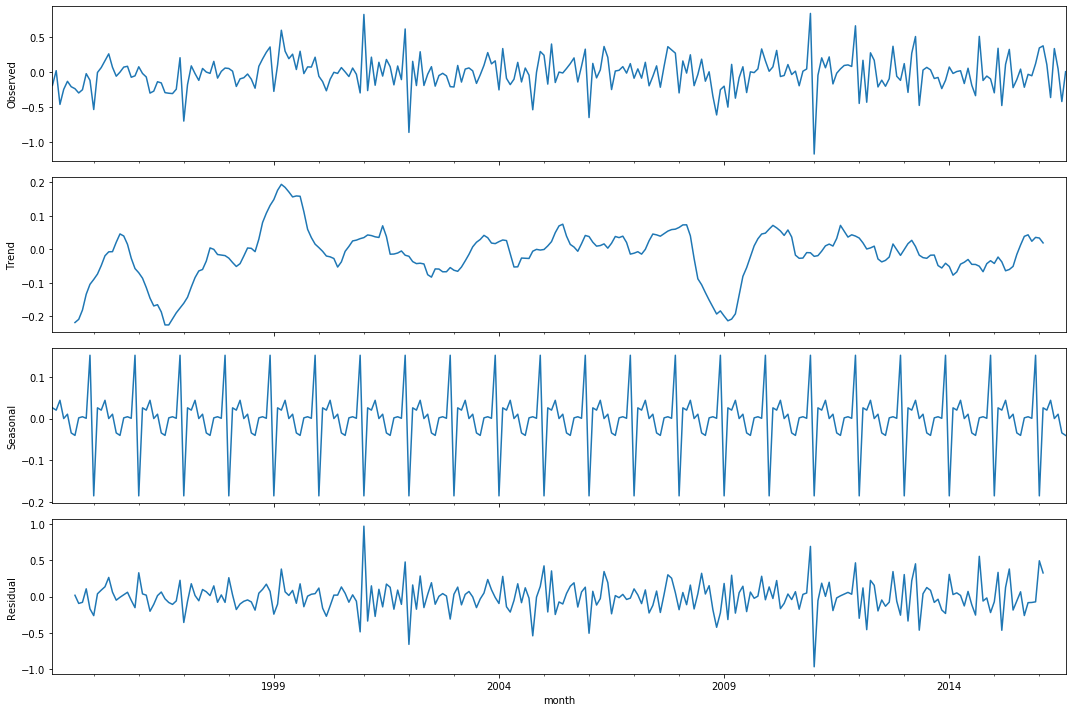

In [8]:
wag['WAG_C_M_diff_second'] = wag['WAG_C_M_diff'] - wag['WAG_C_M_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wag['WAG_C_M_diff_second'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag['WAG_C_M_diff_second'][13:])[1])

Полученный ряд уже выглядит стациораным, гипотезу о нестационарности с уверенностью отвергаем.

In [9]:
wag.tail()

,WAG_C_M,WAG_C_M_box,WAG_C_M_diff,WAG_C_M_diff_second
month,,,,
2016-04-01,36497.0,56.526742,0.942729,-0.366210
2016-05-01,37270.0,56.860441,1.275065,0.332336
2016-06-01,38447.0,57.358885,1.316994,0.041929
2016-07-01,35888.0,56.260153,0.893671,-0.423323
2016-08-01,34095.0,55.455409,0.896620,0.002949


Параметры d и D мы нашли  
d = 1  
D = 1

Подберём параметры p, P, q, Q для этого посмотрим на ACF и PACF полученного ряда.

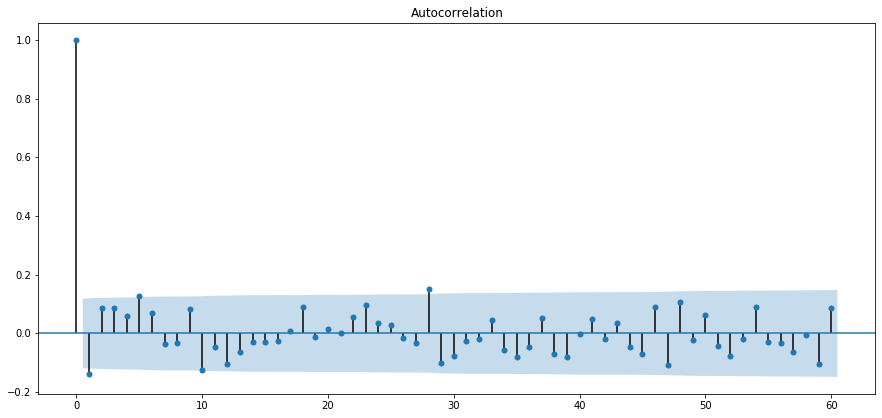

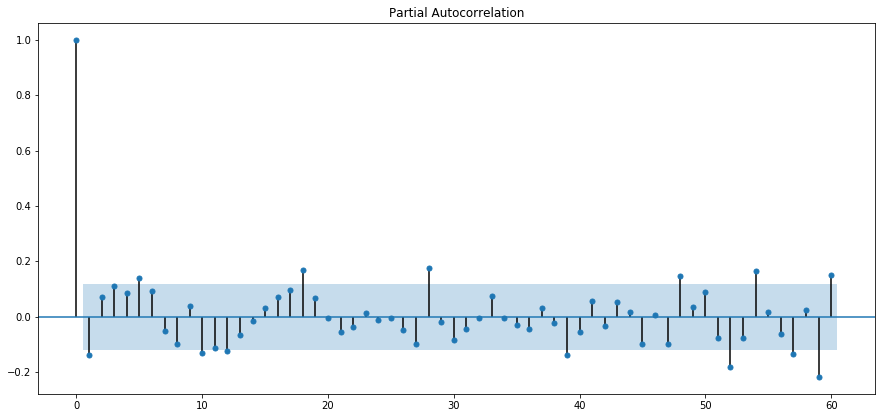

In [10]:
plt.figure(figsize(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag['WAG_C_M_diff_second'][13:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag['WAG_C_M_diff_second'][13:].values.squeeze(), lags=60, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=5, P=5, p=10

In [11]:
ps = [0, 1, 5]
d=1
qs = [0, 1, 5, 10]
Ps = range(0, 6)
D=1
Qs = range(0, 1)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [13]:
%%time
#Осторожно, модель может считаться около 10 минут
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag['WAG_C_M_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 10min 34s


In [14]:
# лучшие модели
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
61  (5, 5, 1, 0) -25.090430
62  (5, 5, 2, 0) -23.332039
65  (5, 5, 5, 0) -22.635295
60  (5, 5, 0, 0) -22.316118
63  (5, 5, 3, 0) -21.512289


In [15]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.545
Date:                            Sat, 25 Jul 2020   AIC                            -25.090
Time:                                    11:25:23   BIC                             18.135
Sample:                                01-01-1993   HQIC                            -7.735
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2200      0.594     -0.371      0.711      -1.384       0.944
ar.L2          0.2427      0.418   

Проверим критерием Стьюдента гипотезу несмещённости.  
Нулевая гипотеза: остатки несмещеные  
Альтернативная гипотеза: смещеные

И критерием Дики-Фулера гипотезу нестационарности  
Нулевая гипотеза: ряд не стационарный  
Альтернативная гипотеза: ряд стационарный

Критерий Стьюдента: p=0.635980
Критерий Дики-Фуллера: p=0.000000


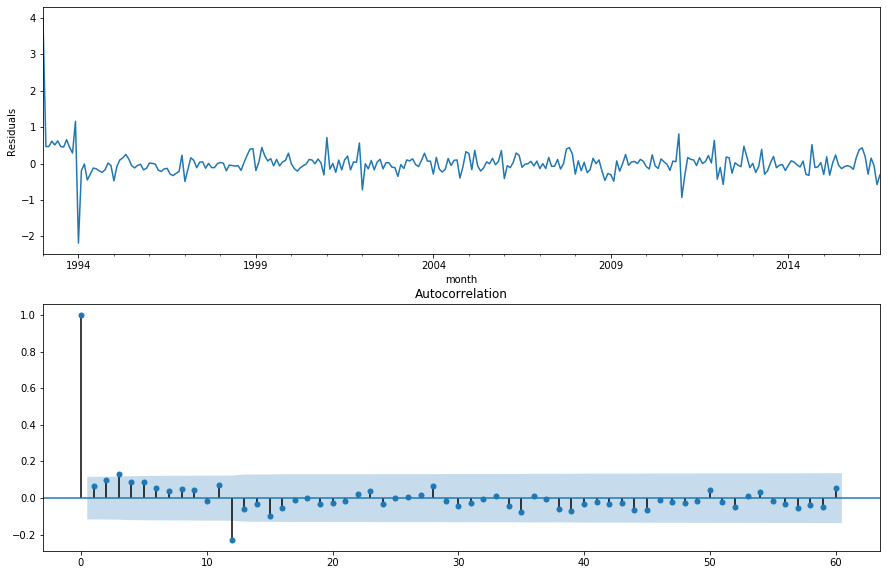

In [24]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=60, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки несмещены (среднее скорее всего равно нулю) и стационарны.

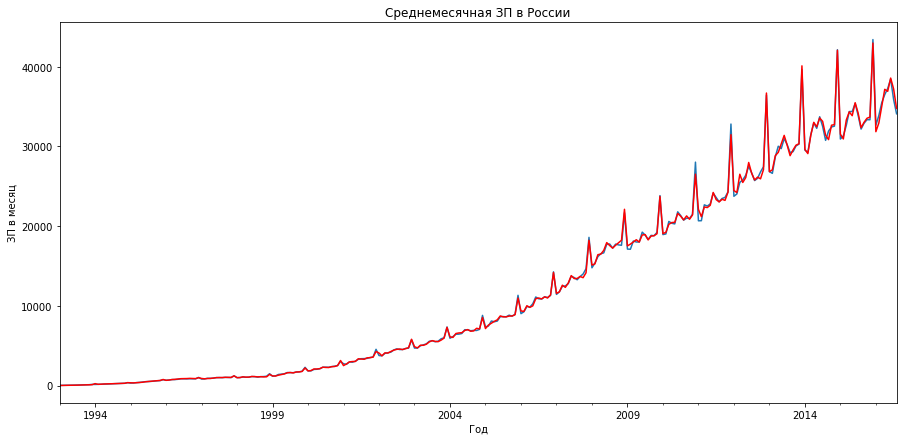

In [21]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wag['WAG_C_M'].plot()
wag['model'].plot(color='r')
plt.ylabel('ЗП в месяц')
plt.xlabel('Год')
plt.title('Среднемесячная ЗП в России')
pylab.show()

### Прогноз  
на 2 года

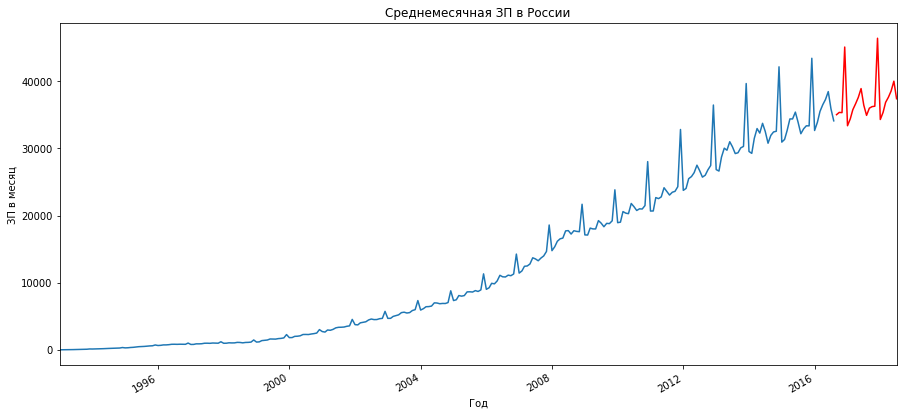

In [22]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=wag.shape[0], end=wag.shape[0]+24), lmbda)

plt.figure(figsize(15,7))
wag2['WAG_C_M'].plot()
wag2['forecast'].plot(color='r')
plt.ylabel('ЗП в месяц')
plt.xlabel('Год')
plt.title('Среднемесячная ЗП в России')
pylab.show()